## Imports

In [3]:
import os
import hdf5storage
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageDraw

In [4]:
DATASETS_PATH = Path('../datasets')
SOURCE_PATH = DATASETS_PATH / 'COMBINED'
# DESTINATION_PATH = DATASETS_PATH / 'COMBINED_FLIPPED'
DESTINATION_PATH = DATASETS_PATH / 'processed' / 'COMBINED_FLIPPED_WITH_NOSE'
TEST_DESTINATION_PATH = DESTINATION_PATH / 'test'
TRAIN_DESTINATION_PATH = DESTINATION_PATH / 'train'

if not DESTINATION_PATH.exists():
    DESTINATION_PATH.mkdir()

if not TEST_DESTINATION_PATH.exists():
    TEST_DESTINATION_PATH.mkdir()

if not TRAIN_DESTINATION_PATH.exists():
    TRAIN_DESTINATION_PATH.mkdir()

In [5]:
import shutil

shutil.copy('../extras/test/see_bboxes.m', str(TEST_DESTINATION_PATH/'see_bboxes.m'))
shutil.copy('../extras/train/see_bboxes.m', str(TRAIN_DESTINATION_PATH/'see_bboxes.m'))

'..\\datasets\\COMBINED_FLIPPED_WITH_NOSE\\train\\see_bboxes.m'

In [6]:
class ColumnStruct:
    def __init__ (self, filename, header, label_by_index = False):
        self.filename = filename
        self.header = header
        self.bbox_and_label = []
        self.label_by_index = label_by_index

    def add (self, bbox, label):
        combine = (
            np.array([[bbox[0]]], dtype=np.uint8),
            np.array([[bbox[1]]], dtype=np.uint8),
            np.array([[bbox[2]]], dtype=np.uint8),
            np.array([[bbox[3]]], dtype=np.uint8), 
            np.array(label, dtype=np.str_ if not self.label_by_index else np.uint8)                
            )
        self.bbox_and_label.append(combine)

    def entry (self):
        return (
            np.array([self.filename], dtype=np.str_),
            np.array([self.bbox_and_label], dtype=[(elem, 'O') for elem in self.header[1:]])
        )

## Settings

In [7]:
combined_container = []
tset = 'test'

img_index = None

draw_bbox = False

include_lfpw = True
include_helen = True

## LFPW Flip augmentation

In [8]:
if include_lfpw:
    LFPW_PATH = Path('../datasets/raw/lfpw-labelled-face-parts-in-the-wild/')
    LFPW_TESTSET = LFPW_PATH / 'testset'
    LFPW_TRAINSET = LFPW_PATH / 'trainset'

    print(f'{os.path.basename(LFPW_PATH)} test path {"exists" if LFPW_TESTSET.exists() else "does not exist"}')
    print(f'{os.path.basename(LFPW_PATH)} train path {"exists" if LFPW_TRAINSET.exists() else "does not exist"}')

    print(f'{os.path.basename(LFPW_PATH)} test set contains {len(os.listdir(LFPW_TESTSET))} images')
    print(f'{os.path.basename(LFPW_PATH)} train set contains {len(os.listdir(LFPW_TRAINSET))} images')

    lfpw_data_path = {
        'test' : LFPW_TESTSET,
        'train' : LFPW_TRAINSET
    }

    lfpw_landmarks = {
        'left_brow' : list(range(17, 22)),
        'right_brow' : list(range(22, 27)),
        'left_eye' : list(range(36, 42)),
        'right_eye' : list(range(42, 48)),
        'nose' : list(range(27, 35)),
        'face_bounds' : list(range(0, 27)),
        'lower_face' : list(range(0, 17)),
        'left_eye_lash' : [36, 37, 38, 39],
        'left_eye_lid' : [36, 41, 40, 39],
        'right_eye_lash' : [42, 43, 44, 45],
        'right_eye_lid' : [42, 47, 46, 45]
    }


lfpw-labelled-face-parts-in-the-wild test path exists
lfpw-labelled-face-parts-in-the-wild train path exists
lfpw-labelled-face-parts-in-the-wild test set contains 448 images
lfpw-labelled-face-parts-in-the-wild train set contains 1622 images


C:\Users\MTinaco\AppData\Local\Temp\ipykernel_13340\3790035564.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 311 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_13340\3790035564.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 260 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  np.array([[bbox[1]]], dtype=np.uint8),
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_13340\3790035564.py:11: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 273 to uint8 will fail

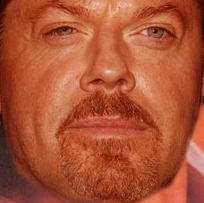

In [9]:
face_img_mirrored = None

if include_lfpw:

    count = 0

    it = iter(sorted(os.listdir(lfpw_data_path[tset])))
    for data in it:
        img = data
        pts = next(it)

        img_path = lfpw_data_path[tset] / img
        pts_path = lfpw_data_path[tset] / pts

        full_img = Image.open(img_path)
        full_pts = np.loadtxt(pts_path, comments=("version:", "n_points:", "{", "}"))

        left_of_face = int(np.min(full_pts[:,0]))
        right_of_face = int(np.max(full_pts[:,0]))
        top_of_face = int(np.min(full_pts[:,1]))
        bottom_of_face = int(np.max(full_pts[:,1]))

        face_img = full_img.crop((left_of_face, top_of_face, right_of_face, bottom_of_face))

        # left_offset = face_img.width*0.1
        # top_offset = face_img.height*0.1
        # right_offset = face_img.width*0.1
        # bottom_offset = face_img.height*0.1

        left_offset = 20
        top_offset = 20
        right_offset = 20
        bottom_offset = 20

        # LEFT EYE

        left_eye_left = int(np.min(full_pts[:,0][np.array(lfpw_landmarks['left_eye'])]))
        left_eye_right = int(np.max(full_pts[:,0][np.array(lfpw_landmarks['left_eye'])]))
        left_eye_top = int(np.min(full_pts[:,1][np.array(lfpw_landmarks['left_eye_lash'])]))
        left_eye_bottom = int(np.max(full_pts[:,1][np.array(lfpw_landmarks['left_eye_lid'])]))

        left_eye_left_localized = left_eye_left - left_of_face - left_offset
        left_eye_top_localized = left_eye_top - top_of_face - top_offset
        left_eye_right_localized = left_eye_right - left_of_face + right_offset
        left_eye_bottom_localized = left_eye_bottom - top_of_face + bottom_offset

        if left_eye_left_localized < 0:
            left_eye_left_localized = 0

        if left_eye_top_localized < 0:
            left_eye_top_localized = 0

        if left_eye_bottom_localized >= (face_img.height - 1) :
            left_eye_bottom_localized = face_img.height - 1

        assert left_eye_left_localized < face_img.width, "left eye: left < width"
        assert left_eye_right_localized < face_img.width, "left eye: right < width"
        assert left_eye_bottom_localized < face_img.height, "left eye: bottom < height"
        assert left_eye_top_localized < face_img.height, "left eye: top < height"

        assert left_eye_left_localized >= 0, "left eye: left >= 0"
        assert left_eye_right_localized >= 0, "left eye: right >= 0"
        assert left_eye_bottom_localized >= 0, "left eye: bottom >= 0"
        assert left_eye_top_localized >= 0, "left eye: top >= 0"

        # RIGHT EYE

        right_eye_left = int(np.min(full_pts[:,0][np.array(lfpw_landmarks['right_eye'])]))
        right_eye_right = int(np.max(full_pts[:,0][np.array(lfpw_landmarks['right_eye'])]))
        right_eye_top = int(np.min(full_pts[:,1][np.array(lfpw_landmarks['right_eye_lash'])]))
        right_eye_bottom = int(np.max(full_pts[:,1][np.array(lfpw_landmarks['right_eye_lid'])]))

        right_eye_left_localized = right_eye_left - left_of_face - left_offset
        right_eye_top_localized = right_eye_top - top_of_face - top_offset
        right_eye_right_localized = right_eye_right - left_of_face + right_offset
        right_eye_bottom_localized = right_eye_bottom - top_of_face + bottom_offset

        if right_eye_right_localized >= (face_img.width - 1):
            right_eye_right_localized = face_img.width - 1

        if right_eye_top_localized < 0:
            right_eye_top_localized = 0

        if right_eye_bottom_localized >= (face_img.height - 1) :
            right_eye_bottom_localized = face_img.height - 1

        assert right_eye_left_localized < face_img.width, "right eye: left < width"
        assert right_eye_right_localized < face_img.width, "right eye: right < width"
        assert right_eye_bottom_localized < face_img.height, "right eye: bottom < height"
        assert right_eye_top_localized < face_img.height, "right eye: top < height"

        assert right_eye_left_localized >= 0, "right eye: left >= 0"
        assert right_eye_right_localized >= 0, "right eye: right >= 0"
        assert right_eye_bottom_localized >= 0, "right eye: bottom >= 0"
        assert right_eye_top_localized >= 0, "right eye: top >= 0"

        nose_left = int(np.min(full_pts[:,0][np.array(lfpw_landmarks['nose'])]))
        nose_right = int(np.max(full_pts[:,0][np.array(lfpw_landmarks['nose'])]))
        nose_top = int(np.min(full_pts[:,1][np.array(lfpw_landmarks['nose'])]))
        nose_bottom = int(np.max(full_pts[:,1][np.array(lfpw_landmarks['nose'])]))

        nose_left_localized = nose_left - left_of_face - int(left_offset/1)
        nose_right_localized = nose_right - left_of_face + int(right_offset/1)
        nose_top_localized = nose_top - top_of_face - int(top_offset/1)
        nose_bottom_localized = nose_bottom - top_of_face + int(bottom_offset/1)

        if nose_right_localized >= (face_img.width - 2):
            nose_right_localized = face_img.width - 2

        if nose_left_localized < 1:
            nose_left_localized = 1

        if nose_top_localized < 1:
            nose_top_localized = 1

        if nose_bottom_localized >= (face_img.height - 2) :
            nose_bottom_localized = face_img.height - 2

        left_eye_bbox = [
            int(left_eye_bottom_localized - left_eye_top_localized),
            int(left_eye_left_localized),
            int(left_eye_top_localized),
            int(left_eye_right_localized - left_eye_left_localized),
        ]

        right_eye_bbox = [
            int(right_eye_bottom_localized - right_eye_top_localized),
            int(right_eye_left_localized),
            int(right_eye_top_localized),
            int(right_eye_right_localized - right_eye_left_localized)
        ]

        nose_bbox = [
            int(nose_bottom_localized - nose_top_localized),
            int(nose_left_localized),
            int(nose_top_localized),
            int(nose_right_localized - nose_left_localized)
        ]

        orig_struct = ColumnStruct (filename=img, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
        orig_struct.add(left_eye_bbox, 1)
        orig_struct.add(right_eye_bbox, 1)
        orig_struct.add(nose_bbox, 2)
        combined_container.append(orig_struct.entry())

        if draw_bbox:
            draw = ImageDraw.Draw(face_img)
            draw.rectangle((left_eye_left_localized, left_eye_top_localized, left_eye_right_localized, left_eye_bottom_localized), outline='yellow')
            draw.rectangle((right_eye_left_localized, right_eye_top_localized, right_eye_right_localized, right_eye_bottom_localized), outline='yellow')
        else:
            face_img.save(DESTINATION_PATH / tset / img)

        # MIRROR AUGMENTATION

        face_img_mirrored = ImageOps.mirror(face_img)

        mirrored_left_eye_left = face_img_mirrored.width - right_eye_right_localized
        mirrored_left_eye_right = face_img_mirrored.width -  right_eye_left_localized
        mirrored_left_eye_top = right_eye_top_localized
        mirrored_left_eye_bottom = right_eye_bottom_localized

        mirrored_right_eye_left = face_img_mirrored.width - left_eye_right_localized
        mirrored_right_eye_right = face_img_mirrored.width - left_eye_left_localized
        mirrored_right_eye_top = left_eye_top_localized
        mirrored_right_eye_bottom = left_eye_bottom_localized

        mirrored_nose_left = face_img_mirrored.width - nose_right_localized
        mirrored_nose_right = face_img_mirrored.width - nose_left_localized
        mirrored_nose_top = nose_top_localized
        mirrored_nose_bottom = nose_bottom_localized

        assert mirrored_left_eye_left < face_img.width, "left eye: left < width"
        assert mirrored_left_eye_right < face_img.width, "left eye: right < width"
        assert mirrored_left_eye_bottom < face_img.height, "left eye: bottom < height"
        assert mirrored_left_eye_top < face_img.height, "left eye: top < height"

        assert mirrored_left_eye_left >= 0, "left eye: left >= 0"
        assert mirrored_left_eye_right >= 0, "left eye: right >= 0"
        assert mirrored_left_eye_bottom >= 0, "left eye: bottom >= 0"
        assert mirrored_left_eye_top >= 0, "left eye: top >= 0"

        mirrored_left_eye_bbox = [
            mirrored_left_eye_bottom - mirrored_left_eye_top,
            mirrored_left_eye_left,
            mirrored_left_eye_top,
            mirrored_left_eye_right - mirrored_left_eye_left
        ]

        mirrored_right_eye_bbox = [
            mirrored_right_eye_bottom - mirrored_right_eye_top,
            mirrored_right_eye_left,
            mirrored_right_eye_top,
            mirrored_right_eye_right - mirrored_right_eye_left
        ]

        mirrored_nose_bbox = [
            mirrored_nose_bottom - mirrored_nose_top,
            mirrored_nose_left,
            mirrored_nose_top,
            mirrored_nose_right - mirrored_nose_left
        ]

        mirrored_img_name = f"{img.split('.')[0]}_mirrored.{img.split('.')[1]}"
        mirrored_struct = ColumnStruct (filename=mirrored_img_name, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
        mirrored_struct.add(mirrored_left_eye_bbox, 1)
        mirrored_struct.add(mirrored_right_eye_bbox, 1)
        mirrored_struct.add(mirrored_nose_bbox, 2)
        combined_container.append(mirrored_struct.entry())

        if draw_bbox:
            draw = ImageDraw.Draw(face_img_mirrored)
            draw.rectangle((mirrored_left_eye_left, mirrored_left_eye_top, mirrored_left_eye_right, mirrored_left_eye_bottom), outline='yellow')
            draw.rectangle((mirrored_right_eye_left, mirrored_right_eye_top, mirrored_right_eye_right, mirrored_right_eye_bottom), outline='yellow')
        else:
            face_img_mirrored.save(DESTINATION_PATH / tset / mirrored_img_name)

        if img_index:
            if count > img_index: break
            count += 1

face_img_mirrored

## HELEN Flip Augmentation

In [10]:
if include_helen:
    HELEN_PATH = Path('../datasets/raw/HELEN')
    HELEN_TESTSET = HELEN_PATH / 'test'
    HELEN_TRAINSET = HELEN_PATH / 'train'

    print(f'HELEN test path {"exists" if HELEN_TESTSET.exists() else "does not exist"}')
    print(f'HELEN train path {"exists" if HELEN_TRAINSET.exists() else "does not exist"}')

    print(f'HELEN test set contains {len(os.listdir(HELEN_TESTSET))} images')
    print(f'HELEN train set contains {len(os.listdir(HELEN_TRAINSET))} images')

    helen_data_path = {
        'test' : HELEN_TESTSET,
        'train' : HELEN_TRAINSET
    }

    helen_landmarks = {
        'left_brow' : list(range(174, 193)),
        'right_brow' : list(range(154, 173)),
        'left_eye' : list(range(134, 153)),
        'right_eye' : list(range(114, 133)),
        'nose' : list(range(41, 57)),
        'face_bounds' : list(range(0, 184)),
        'lower_face' : list(range(0, 39)),
        'outer_lips' : list(range(58, 85)),
        'inner_lips' : list(range(86, 113)),
        'left_eye_lash' : [144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134],
        'left_eye_lid' : [145, 146, 147, 148, 149, 150, 151, 152, 153],
        'right_eye_lash' : [114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
        'right_eye_lid' : [133, 132, 131, 130, 129, 128, 127, 126, 125, 125]
    }


HELEN test path exists
HELEN train path exists
HELEN test set contains 330 images
HELEN train set contains 2000 images


## Helen annotations

In [11]:
if include_helen:
    from collections import defaultdict
    import json

    helen_annotations = defaultdict(str)

    annotation_path = HELEN_PATH / "annotation" / "annotation"
    print(f'HELEN annotation path {"exists" if annotation_path.exists() else "does not exist"}')

    test_image_names = [Path(file.strip('\n')).stem for file in os.listdir(HELEN_TESTSET)]
    train_image_names = [Path(file.strip('\n')).stem for file in os.listdir(HELEN_TRAINSET)]

    test_annotations = []
    train_annotations = []

    for txt_file in os.listdir(annotation_path):
        with open (annotation_path / txt_file, 'r') as annotation_txt:
            lines = annotation_txt.readlines()

            img_name = lines.pop(0).strip('\n')

            if img_name in test_image_names:
                # print(f"{img_name} in test images")
                test_annotations.append(img_name)

            if img_name in train_image_names:
                # print(f"{img_name} in train images")
                train_annotations.append(img_name)

            helen_annotations[img_name] = []
            for coord in lines:
                x, y = tuple(coord.rstrip('\n').split(','))
                helen_annotations[img_name].append((float(x), float(y)))

    print(f'HELEN test images are {"100%" if len(test_image_names) == len(test_annotations) else "<100%"} annotated')
    print(f'HELEN train images are {"100%" if len(train_image_names) == len(train_annotations) else "<100%"} annotated')

    out_file = open('helen_annotations.json', 'w')
    json.dump(helen_annotations, out_file, indent=4)

HELEN annotation path exists
HELEN test images are 100% annotated
HELEN train images are 100% annotated


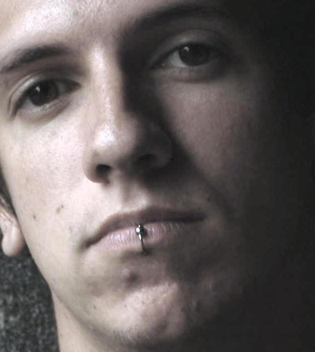

In [12]:
face_img_mirrored = None

if include_helen:

    symmetrical_scale = 0.5

    scale_width = symmetrical_scale
    scale_height = symmetrical_scale

    it = iter(sorted(os.listdir(helen_data_path[tset])))

    count = 0

    for data in it:
        img = data
        img_path = helen_data_path[tset] / img

        full_pts = np.array(helen_annotations[img_path.stem])
        full_img = Image.open(img_path)

        left_of_face = int(np.min(full_pts[:,0]))
        right_of_face = int(np.max(full_pts[:,0]))
        top_of_face = int(np.min(full_pts[:,1]))
        bottom_of_face = int(np.max(full_pts[:,1]))

        face_img = full_img.crop((left_of_face, top_of_face, right_of_face, bottom_of_face))
        cropped_face_img = face_img.resize((int(face_img.width*scale_width), int(face_img.height*scale_height)))

        # left_offset = cropped_face_img.width*0.15
        # top_offset = cropped_face_img.height*0.15
        # right_offset = cropped_face_img.width*0.15
        # bottom_offset = cropped_face_img.height*0.15

        left_offset = 10
        top_offset = 10
        right_offset = 10
        bottom_offset = 10


        # LEFT EYE

        left_eye_left = int(np.min(full_pts[:,0][np.array(helen_landmarks['left_eye'])]))
        left_eye_right = int(np.max(full_pts[:,0][np.array(helen_landmarks['left_eye'])]))
        left_eye_top = int(np.min(full_pts[:,1][np.array(helen_landmarks['left_eye_lash'])]))
        left_eye_bottom = int(np.max(full_pts[:,1][np.array(helen_landmarks['left_eye_lid'])]))

        left_eye_left_localized = (left_eye_left - left_of_face)*scale_width - left_offset
        left_eye_top_localized = (left_eye_top - top_of_face)*scale_height - top_offset
        left_eye_right_localized = (left_eye_right - left_of_face)*scale_width + right_offset
        left_eye_bottom_localized = (left_eye_bottom - top_of_face)*scale_height + bottom_offset

        if left_eye_left_localized <= 0:
            left_eye_left_localized = 0

        if left_eye_top_localized <= 0:
            left_eye_top_localized = 0

        if left_eye_bottom_localized >= (cropped_face_img.height - 1) :
            left_eye_bottom_localized = cropped_face_img.height - 1

        assert left_eye_left_localized < cropped_face_img.width, "left eye: left < width"
        assert left_eye_right_localized < cropped_face_img.width, "left eye: right < width"
        assert left_eye_bottom_localized < cropped_face_img.height, "left eye: bottom < height"
        assert left_eye_top_localized < cropped_face_img.height, "left eye: top < height"

        assert left_eye_left_localized >= 0, "left eye: left >= 0"
        assert left_eye_right_localized >= 0, "left eye: right >= 0"
        assert left_eye_bottom_localized >= 0, "left eye: bottom >= 0"
        assert left_eye_top_localized >= 0, "left eye: top >= 0"


        # RIGHT EYE

        right_eye_left = int(np.min(full_pts[:,0][np.array(helen_landmarks['right_eye'])]))
        right_eye_right = int(np.max(full_pts[:,0][np.array(helen_landmarks['right_eye'])]))
        right_eye_top = int(np.min(full_pts[:,1][np.array(helen_landmarks['right_eye_lash'])]))
        right_eye_bottom = int(np.max(full_pts[:,1][np.array(helen_landmarks['right_eye_lid'])]))

        right_eye_left_localized = (right_eye_left - left_of_face)*scale_width - left_offset
        right_eye_top_localized = (right_eye_top - top_of_face)*scale_height - top_offset
        right_eye_right_localized = (right_eye_right - left_of_face)*scale_width + right_offset
        right_eye_bottom_localized = (right_eye_bottom - top_of_face)*scale_height + bottom_offset

        if right_eye_top_localized < 0:
            right_eye_top_localized = 0

        if right_eye_bottom_localized >= (cropped_face_img.height - 1) :
            right_eye_bottom_localized = cropped_face_img.height - 1

        if right_eye_right_localized >= (cropped_face_img.width - 1):
            right_eye_right_localized = cropped_face_img.width - 1


        assert right_eye_left_localized < cropped_face_img.width, "right eye: left < width"
        assert right_eye_right_localized < cropped_face_img.width, "right eye: right < width"
        assert right_eye_bottom_localized < cropped_face_img.height, "right eye: bottom < height"
        assert right_eye_top_localized < cropped_face_img.height, "right eye: top < height"

        assert right_eye_left_localized >= 0, "right eye: left >= 0"
        assert right_eye_right_localized >= 0, "right eye: right >= 0"
        assert right_eye_bottom_localized >= 0, "right eye: bottom >= 0"
        assert right_eye_top_localized >= 0, "right eye: top >= 0"

        nose_left = int(np.min(full_pts[:,0][np.array(helen_landmarks['nose'])]))
        nose_right = int(np.max(full_pts[:,0][np.array(helen_landmarks['nose'])]))
        nose_top = int(np.min(full_pts[:,1][np.array(helen_landmarks['nose'])]))
        nose_bottom = int(np.max(full_pts[:,1][np.array(helen_landmarks['nose'])]))

        nose_left_localized = (nose_left - left_of_face)*scale_width - int(left_offset/1)
        nose_top_localized = (nose_top - top_of_face)*scale_height - int(top_offset/1)
        nose_right_localized = (nose_right - left_of_face)*scale_width + int(right_offset/1)
        nose_bottom_localized = (nose_bottom - top_of_face)*scale_height + int(bottom_offset/1)

        if nose_right_localized >= (face_img.width - 2):
            nose_right_localized = face_img.width - 2

        if nose_left_localized < 1:
            nose_left_localized = 1

        if nose_top_localized < 1:
            nose_top_localized = 1

        if nose_bottom_localized >= (face_img.height - 2) :
            nose_bottom_localized = face_img.height - 2


        left_eye_bbox = [
            left_eye_bottom_localized - left_eye_top_localized,
            left_eye_left_localized,
            left_eye_top_localized,
            left_eye_right_localized - left_eye_left_localized
        ]

        right_eye_bbox = [
            right_eye_bottom_localized - right_eye_top_localized,
            right_eye_left_localized,
            right_eye_top_localized,
            right_eye_right_localized - right_eye_left_localized
        ]

        nose_bbox = [
            nose_bottom_localized - nose_top_localized,
            nose_left_localized,
            nose_top_localized,
            nose_right_localized - nose_left_localized
        ]

        orig_struct = ColumnStruct (filename=img, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
        orig_struct.add(left_eye_bbox, 1)
        orig_struct.add(right_eye_bbox, 1)
        orig_struct.add(nose_bbox, 2)
        combined_container.append(orig_struct.entry())
        
        if draw_bbox:
            draw = ImageDraw.Draw(cropped_face_img)
            draw.rectangle((left_eye_left_localized, left_eye_top_localized, left_eye_right_localized, left_eye_bottom_localized), outline='yellow')
            draw.rectangle((right_eye_left_localized, right_eye_top_localized, right_eye_right_localized, right_eye_bottom_localized), outline='yellow')
        else:
            face_img.save(DESTINATION_PATH / tset / img)

        face_img_mirrored = ImageOps.mirror(cropped_face_img)

        mirrored_left_eye_left = face_img_mirrored.width - right_eye_right_localized
        mirrored_left_eye_right = face_img_mirrored.width -  right_eye_left_localized
        mirrored_left_eye_top = right_eye_top_localized
        mirrored_left_eye_bottom = right_eye_bottom_localized

        mirrored_right_eye_left = face_img_mirrored.width - left_eye_right_localized
        mirrored_right_eye_right = face_img_mirrored.width - left_eye_left_localized
        mirrored_right_eye_top = left_eye_top_localized
        mirrored_right_eye_bottom = left_eye_bottom_localized

        mirrored_nose_left = face_img_mirrored.width - nose_right_localized
        mirrored_nose_right = face_img_mirrored.width - nose_left_localized
        mirrored_nose_top = nose_top_localized
        mirrored_nose_bottom = nose_bottom_localized

        assert mirrored_left_eye_left < face_img_mirrored.width, "left eye: left < width"
        assert mirrored_left_eye_right < face_img_mirrored.width, "left eye: right < width"
        assert mirrored_left_eye_bottom < face_img_mirrored.height, "left eye: bottom < height"
        assert mirrored_left_eye_top < face_img_mirrored.height, "left eye: top < height"

        assert mirrored_left_eye_left >= 0, "left eye: left >= 0"
        assert mirrored_left_eye_right >= 0, "left eye: right >= 0"
        assert mirrored_left_eye_bottom >= 0, "left eye: bottom >= 0"
        assert mirrored_left_eye_top >= 0, "left eye: top >= 0"

        mirrored_left_eye_bbox = [
            mirrored_left_eye_bottom - mirrored_left_eye_top,
            mirrored_left_eye_left,
            mirrored_left_eye_top,
            mirrored_left_eye_right - mirrored_left_eye_left
        ]

        mirrored_right_eye_bbox = [
            mirrored_right_eye_bottom - mirrored_right_eye_top,
            mirrored_right_eye_left,
            mirrored_right_eye_top,
            mirrored_right_eye_right - mirrored_right_eye_left
        ]

        mirrored_nose_bbox = [
            mirrored_nose_bottom - mirrored_nose_top,
            mirrored_nose_left,
            mirrored_nose_top,
            mirrored_nose_right - mirrored_nose_left
        ]

        mirrored_img_name = f"{img.split('.')[0]}_mirrored.{img.split('.')[1]}"
        mirrored_struct = ColumnStruct (filename=mirrored_img_name, header=("filename", "height", "left", "top", "width", "label"), label_by_index=True)
        mirrored_struct.add(mirrored_left_eye_bbox, 1)
        mirrored_struct.add(mirrored_right_eye_bbox, 1)
        mirrored_struct.add(mirrored_nose_bbox, 2)
        combined_container.append(mirrored_struct.entry())

        if draw_bbox:
            draw = ImageDraw.Draw(face_img_mirrored)
            draw.rectangle((mirrored_left_eye_left, mirrored_left_eye_top, mirrored_left_eye_right, mirrored_left_eye_bottom), outline='yellow')
            draw.rectangle((mirrored_right_eye_left, mirrored_right_eye_top, mirrored_right_eye_right, mirrored_right_eye_bottom), outline='yellow')
        else:
            face_img_mirrored.save(DESTINATION_PATH / tset / mirrored_img_name)

        if img_index:
            if count > img_index: break
            count += 1
        
face_img_mirrored

In [13]:
matrix = {'digitStruct' : np.array([combined_container], dtype=[('name', 'O'), ('bbox', 'O')])}
hdf5storage.write(matrix, '.', str(DESTINATION_PATH / tset / 'digitStruct.mat') , matlab_compatible=True)